# Sistemas Inteligentes: Aprendizaje Automático

**Autor:** _Guillermo Facundo Colunga, uo236856@uniovi.es_

**Datos entorno desarrollo:**  
**SO:** Windows 10.  
**Cores:** 32/64.  
**RAM:** 64 Gb.

# Introducción

Esta práctica de aprendizaje automático se enmarca en explorar los distintos paradigmas de clasificación estudiados en la asignatura para seleccionar aquel que mejor prediga el tipo de actividad que realiza una persona según la información proporcionada por los sensores que lleva una persona.

Para ello se evaluarán los paradigmas de clasificación **árbol de decisión, vecinos más cercanos, redes neuronales y máquinas de vector soporte** a través del paquete `caret` de R. 

Finalmente se realizará la comparación de los resultados aportados por los diferentes paradigmas y se seleccionará aquel que mejor precisión tenga como _el mejor_.


# Configuración espacio de trabajo en R

Empezamos configurando R e importanto el paquete `caret`. De la misma forma cargamos las librerías necesarias que vamos a utilizar durante el desarrollo de la práctica y eliminamos los warnings de nuestro script para limpiar las salidas.

In [2]:
# Eliminamos los warnings del script ya que ensucian el script
options(warn=-1)

# Realizamos los imports necesarios
library(caret)

Loading required package: lattice

Loading required package: ggplot2



# Carga de datos en R

Una vez tenemos R configurado y con las librerías necesarias cargadas, importamos los datos sobre los que vamos a dearrollar nuestros modelos. Para ello descargamos en el directorio el siguiente banco de [datos](http://archive.ics.uci.edu/ml/datasets/Wearable+Computing%3A+Classification+of+Body+Postures+and+Movements+%28PUC-Rio%29) y lo importamos con el siguiente código.

In [3]:
load("har.RData")

Este conjunto de datos contiene 19 variables y 165.633 instancias, para que el análisis se pueda hacer en menos tiempo usaremos sólo 10.000 instancias que vendrán dadas por nuestro identificador universitario.

In [4]:
# Configuramos nuestro identificador universitario
uo <- 236856
n_instancias <- 10000

Una vez configurados el identificador universitario y el número de instancias filtramos los datos del banco y los asignamos a la variable filtered.

In [5]:
set.seed(uo) #Pon aquí los número de tu UO
filtered <- har[sample(nrow(har)-1,n_instancias),]

Además vamos a eliminar las todas las columnas que contienen información relativa a cada participante en el estudio para emplear sólo la información del movimiento

In [6]:
filtered$age<-NULL
filtered$user<-NULL
filtered$gender<-NULL
filtered$how_tall_in_meters<-NULL
filtered$weight<-NULL
filtered$body_mass_index<-NULL

Mostramos la cabecera de la tabla de datos resultante tras realizar el pre-procesado para ver con que datos vamos a trabajar.

In [7]:
# Mostramos los datos con los que trabajaremos.
head(filtered)

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>
25721,-24,41,-25,-252,-328,-362,26,106,-88,-150,-95,73,sitting
145066,-10,83,-101,-492,-516,-614,36,65,-103,-172,-87,72,walking
110991,-13,97,-86,11,83,-121,40,98,-66,-180,-87,55,standingup
99440,-5,97,-123,0,90,-139,39,116,-83,-182,-81,53,standing
164480,-17,94,-143,-15,76,-83,-10,141,-90,-183,-95,52,walking
37849,-1,67,-66,-24,-29,-25,62,55,-102,-94,-126,67,sitting


En la tabla anterior se puede ver que tenemos las variables x1, y1, z1, ... x4, y4, z4. Cada conjunto (x, y, z) se corresponde con los datos de un acelerómetro ubicado en una extremidad de la persona. La última columna se corresponde con la actividad del registro.

# Esquema de evaluación

Conocemos que existen distintos tipos de validación, cada uno con sus ventajas y desventajas. Sin embargo, para nuestro problema realizaremnos una división 80%/20% para entrenamiento/test. Esto nos permitirá realizar una validación externa para ver como de bueno es realmente el modelo ocn datos que no ha visto durante el procesod e entrenamiento.

In [8]:
training_percentage <- .8

In [9]:
set.seed(uo)
inTrain <- createDataPartition(
    # indicamos la clase
    y = filtered$class,
    
    # el porcentaje de instancias para entrenamiento
    p = training_percentage,
    
    # controla el formato de salida
    list = FALSE
)

# Definimos nuestras particiones de entrenamiento y validación.
training <- filtered[ inTrain,]
testing <- filtered[-inTrain,]

A continuación, como tenemos un gran número de instancias (10.000) emplearemos el sistema de validación cruzada con valor de k 10.

In [10]:
crossValidation <- trainControl(method = "cv", number = 10)

# Métrica de comparación de modelos

A contianuación se muestra el número de datos de cada clase así como el porcentaje de datos de cada clase contenidos en el banco de datos.

In [11]:
cat('Número de datos de cada clase: \n')
summary(filtered$class)
cat('\nPorcentaje de datos de cada clase: \n')
summary(filtered$class)/sum(summary(filtered$class))

Número de datos de cada clase: 


sitting sittingdown    standing  standingup     walking 
       3048         749        2915         738        2550


Porcentaje de datos de cada clase: 


sitting sittingdown    standing  standingup     walking 
     0.3048      0.0749      0.2915      0.0738      0.2550

De los datos anteriores podemos obtener que las clases están desbalanceadas ya que por ejemplo `sitting` representa el 30% de los datos y `sittingdown` el 7%. Por tanto emplearemos la métrica kappa, que nos permite saber cómo de bueno es un clasificador en comparación con una predicción basada en la frecuencia de las clases. Además, dicha métrica tiene en cuenta también el valor del porcentaje de acierto.

# Generación de modelos

In [12]:
# Creamos una función para ver los resultados de la validación interna
internalValidation <- function(model) {
  print(model)
  print(model$results[rownames(model$bestTune),1:4])
}

In [13]:
# Creamos una función para ver los resultados de la validación externa
externalValidation <- function(model, testingData = testing) {
  print(confusionMatrix(predict(model,testingData),testingData$class))
}

## Árboles de decisión

De acuerdo con la teoría, un árbol de decisión es un mecanismo en el que dado un conjunto de datos se fabrican diagramas de construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema. Por lo tanto, y teniendo en cuenta nuestros datos, parece un modelo que nos dará unos buenos resultados, sin embargo, vamos a contrastar esta hipótesis.

Tanto en teroría como en prácticas vimos distintos modelos de árboles de decisión, a continuación implementaremos los modelos J48, rpart y rpart2 para comparar su precisión para el problema dado.

In [14]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con J48.
c4.5Fit <- train(
    class ~ .,
    data = training,
    method = "J48",
    trControl = crossValidation,
    tuneLength = 7,
    metric = "Kappa"
)

In [15]:
# Resultados validación interna
internalValidation(c4.5Fit)

C4.5-like Trees 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  C           M  Accuracy   Kappa    
  0.01000000  1  0.9392670  0.9185082
  0.01000000  2  0.9392660  0.9184999
  0.01000000  3  0.9372659  0.9158047
  0.01000000  4  0.9353918  0.9132995
  0.01000000  5  0.9350171  0.9127954
  0.01000000  6  0.9328938  0.9099341
  0.01000000  7  0.9306432  0.9068584
  0.09166667  1  0.9411417  0.9210545
  0.09166667  2  0.9398906  0.9193559
  0.09166667  3  0.9385145  0.9174796
  0.09166667  4  0.9372654  0.9158107
  0.09166667  5  0.9363915  0.9146582
  0.09166667  6  0.9336434  0.9109447
  0.09166667  7  0.9317677  0.9083989
  0.17333333  1  0.9408915  0.9207371
  0.17333333  2  0.9398903  0.9193995
  0.17333333  3  0.9381404  0.9170223
  0.17333333  4  0.9373

El valor máximo de C es 0.3366667 y podemos observar que el mejor resultado se obtiene con M = 1, a partir de ahí a mayor M peores resultados, por lo que no tiene sentido seguir explorando árboles más complejos. Por tanto los valores C = 0.09166667 y M = 2 son los mejores posebles.

In [16]:
# Resultados validación externa
externalValidation(c4.5Fit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         606           3        0          4       0
  sittingdown       1         130        4         13       4
  standing          0           4      563          9      23
  standingup        2           6        5        111       8
  walking           0           6       11         10     475

Overall Statistics
                                          
               Accuracy : 0.9434          
                 95% CI : (0.9324, 0.9532)
    No Information Rate : 0.3048          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.924           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9951            0.87248          0.9657


**Resultados:**

Validación interna (Acc. = 0.941891 / Kappa = 0.9221043)

Validación externa (Acc. = 0.9434 / Kappa = 0.924)

## CART

Vamos a probar ahora con un árbol de decisión que emplea el algoritmo CART (rpart y rpart2).

### Rpart

Primero probaremos con la versión rpart, que utiliza el parámetro cp (solo se introducirá un nodo en el árbol cuando permita que se reduzca el error en al menos el valor de cp).

In [17]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con rpart.
rpartFit <- train(
    class ~ .,
    data = training,
    method = "rpart",
    trControl = crossValidation,
    tuneLength = 10,
    metric = "Kappa"
)

In [18]:
# Resultados validación interna
internalValidation(rpartFit)

CART 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa    
  0.008268920  0.8567832  0.8064766
  0.009077836  0.8496588  0.7956909
  0.012583139  0.8352895  0.7761521
  0.015279525  0.8214208  0.7565420
  0.018874708  0.8064200  0.7359349
  0.031278087  0.7891728  0.7120112
  0.048804602  0.7669272  0.6829521
  0.057702678  0.6958227  0.5740171
  0.172209240  0.6011079  0.4351829
  0.360057523  0.4021739  0.1437658

Kappa was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.00826892.
          cp  Accuracy     Kappa AccuracySD
1 0.00826892 0.8567832 0.8064766 0.01106354


De la validación interna se puede deducir que a medida que incrementámos el parámetro cp el resultado de la precisión empeora.

In [19]:
# Resultados validación externa
externalValidation(rpartFit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         601          20       12          9       4
  sittingdown       0          81        2         34       9
  standing          0          21      554         49      56
  standingup        3          14        1         47      16
  walking           5          13       14          8     425

Overall Statistics
                                        
               Accuracy : 0.8549        
                 95% CI : (0.8386, 0.87)
    No Information Rate : 0.3048        
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.8025        
                                        
 Mcnemar's Test P-Value : < 2.2e-16     

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9869            0.54362          0.9503
Specificity       

**Resultados:**

Validación interna (Acc. = 0.8567832 / Kappa = 0.8064766)

Validación externa (Acc. = 0.8549 / Kappa = 0.8025)

Se puede observar que tanto en el caso de la validación interna como externa los datos obtenidos con el modelo C4.5 son mejores.

### Rpart2

Ahora probamos con la versión rpart2 que emplea el parámetro maxdepth para controlar la profundidad del árbol. Vamos a modeificar el tunelenght hasta 21 para poder cubrir todos los posibles valores.

In [20]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
rpart2Fit <- train(
    class ~ .,
    data = training,
    method = "rpart2",
    trControl = crossValidation,
    tuneLength = 21,
    metric = "Kappa"
)

In [21]:
# Resultados validación interna
internalValidation(rpart2Fit)

CART 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  maxdepth  Accuracy   Kappa    
   1        0.5551079  0.3687290
   2        0.6739527  0.5403200
   3        0.7149438  0.6027996
   5        0.7804272  0.6997678
   6        0.8021728  0.7300780
   7        0.8154195  0.7483567
   8        0.8256653  0.7623293
  10        0.8476592  0.7929326
  12        0.8480347  0.7934325
  14        0.8480347  0.7934325
  16        0.8480347  0.7934325
  17        0.8480347  0.7934325
  18        0.8480347  0.7934325
  19        0.8480347  0.7934325
  20        0.8480347  0.7934325
  22        0.8480347  0.7934325
  23        0.8480347  0.7934325
  24        0.8480347  0.7934325
  26        0.8480347  0.7934325
  27        0.8480347  0.7934325
  28        0.8480347  0.

Podemos ver que a apartir de una profundidad de 12 el valor de la precisión y de kappa se mantiene constante. Por lo tanto se seleccionará la profundidad de 11 como óptima ya que una más compleja que ofrezca el mismo resultado se considera como una peor opción.

In [22]:
# Resultados validación externa
externalValidation(rpart2Fit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         601          20       12          9       4
  sittingdown       0          81        2         34       9
  standing          0          21      527         49      49
  standingup        3          14        1         47      16
  walking           5          13       41          8     432

Overall Statistics
                                          
               Accuracy : 0.8448          
                 95% CI : (0.8282, 0.8605)
    No Information Rate : 0.3048          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7891          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9869            0.54362          0.9039


**Resultados:**

Validación interna (Acc. = 0.0.8480347 / Kappa = 0.7934325)

Validación externa (Acc. = 0.8448 / Kappa = 0.7891)

Se puede observar que tanto en el caso de la validación interna como externa los datos obtenidos con el modelo C4.5 son mejores. Sin embargo pese a que en la validación interna el árbol rpar2 sea peor que el árbol rpart en la validación externa ambos modelos tienen un rendimiento idéntico.

### Conclusión árboles de decisión

Con los resultados obtenidos podemos decir que el mejor árbol es el C4.5 ya que con nuestro esquema de validación es el que mejor tasa de acierto tiene. Por tanto será el modelo seleccionado de árboles de decisión.

## Vecinos más cercanos (kNN)

Otro de los paradigmas de clasificación vistos durante la asginatura es el de vecinos más cercanos o knn por sus siglas en inglés. Este paradigma no tiene un modelo, lo que hace es comparar el ejemplo con los datos a predecir y a través de distancias a k vecinos más cercanos precedir la clase.

In [23]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con knn.
knnFit <- train(
  class ~ .,
  data = training,
  method = "knn",
  trControl = crossValidation,
  tuneLength = 10, # k. Número de vecinos a comprobar.
  metric = "Kappa"
)

In [24]:
# Resultados validación interna
internalValidation(knnFit)

k-Nearest Neighbors 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.9690072  0.9584312
   7  0.9655076  0.9537173
   9  0.9625084  0.9496858
  11  0.9568850  0.9421188
  13  0.9520121  0.9355667
  15  0.9495134  0.9321781
  17  0.9457637  0.9271268
  19  0.9411423  0.9209002
  21  0.9372688  0.9156601
  23  0.9331438  0.9101012

Kappa was used to select the optimal model using the largest value.
The final value used for the model was k = 5.
  k  Accuracy     Kappa  AccuracySD
1 5 0.9690072 0.9584312 0.002350092


Tras realizar la validación interna se ve que los resultados empeoran a medida que se emplean más vecinos para clasificar. Por tanto se usará k=5 que es el que mejor valor de kappa nos da.

In [25]:
# Resultados validación externa
externalValidation(knnFit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         606           0        0          0       0
  sittingdown       0         140        0          6       4
  standing          0           4      582          2      23
  standingup        3           4        1        138       0
  walking           0           1        0          1     483

Overall Statistics
                                          
               Accuracy : 0.9755          
                 95% CI : (0.9677, 0.9818)
    No Information Rate : 0.3048          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9671          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9951            0.93960          0.9983


**Resultados:**

Validación interna (Acc. = 0.9690072 / Kappa = 0.9584312)

Validación externa (Acc. = 0.9745 / Kappa = 0.9658)

En este modelo puede verse que los resultados con la validación externa superan, muy ligeramente, a los resultados obtenidos durante el aprendizaje.

## Redes neuronales

Este es un método de clasificación no paramétrico, que estima el valor de la función de densidad de probabilidad o directamente la probabilidad a posteriori de que un elemento x pertenezca a la clase C a partir de la información proporcionada por el conjunto de prototipos. En el proceso de aprendizaje no se hace ninguna suposición acerca de la distribución de las variables predictoras.

In [26]:
plotNNErrorEvolution <- function(nnModel){
  ggplot() + geom_line(aes(x=1:length(nnModel$finalModel$IterativeFitError), 
                           y=nnModel$finalModel$IterativeFitError)) +
  xlab("Iteraciones") + ylab("Error") 
}

### 1 capa oculta

In [27]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit <- train(
    class ~ .,
    data = training,
    method = "mlp",
    trControl = crossValidation,
    metric = "Kappa",
    preProcess=c("center","scale"),
    tuneGrid = data.frame(size=seq(9,30,3))
)

nneurons1L <- nn1LFit$results[rownames(nn1LFit$bestTune),1]

In [28]:
# Resultados validación interna
internalValidation(nn1LFit)

Multi-Layer Perceptron 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

Pre-processing: centered (12), scaled (12) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  size  Accuracy   Kappa    
   9    0.9241432  0.8980070
  12    0.9327642  0.9097391
  15    0.9395176  0.9189291
  18    0.9455103  0.9269642
  21    0.9463903  0.9281958
  24    0.9586346  0.9445660
  27    0.9558851  0.9408872
  30    0.9565112  0.9417068

Kappa was used to select the optimal model using the largest value.
The final value used for the model was size = 24.
  size  Accuracy    Kappa  AccuracySD
6   24 0.9586346 0.944566 0.007605064


Con el entrenamiento simple que se ha realizado ya se obtiene un resultado decente. A demás se ve que el abanico de datos proporcionados para el tamaño de la red nos muestran que a partir de 24 neuronas los resultados empeoran.

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         607           1        0          0       0
  sittingdown       2         134        1          5       3
  standing          0           5      548          8      17
  standingup        0           5        6        128       5
  walking           0           4       28          6     485

Overall Statistics
                                          
               Accuracy : 0.952           
                 95% CI : (0.9416, 0.9609)
    No Information Rate : 0.3048          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9355          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9967            0.89933          0.9400


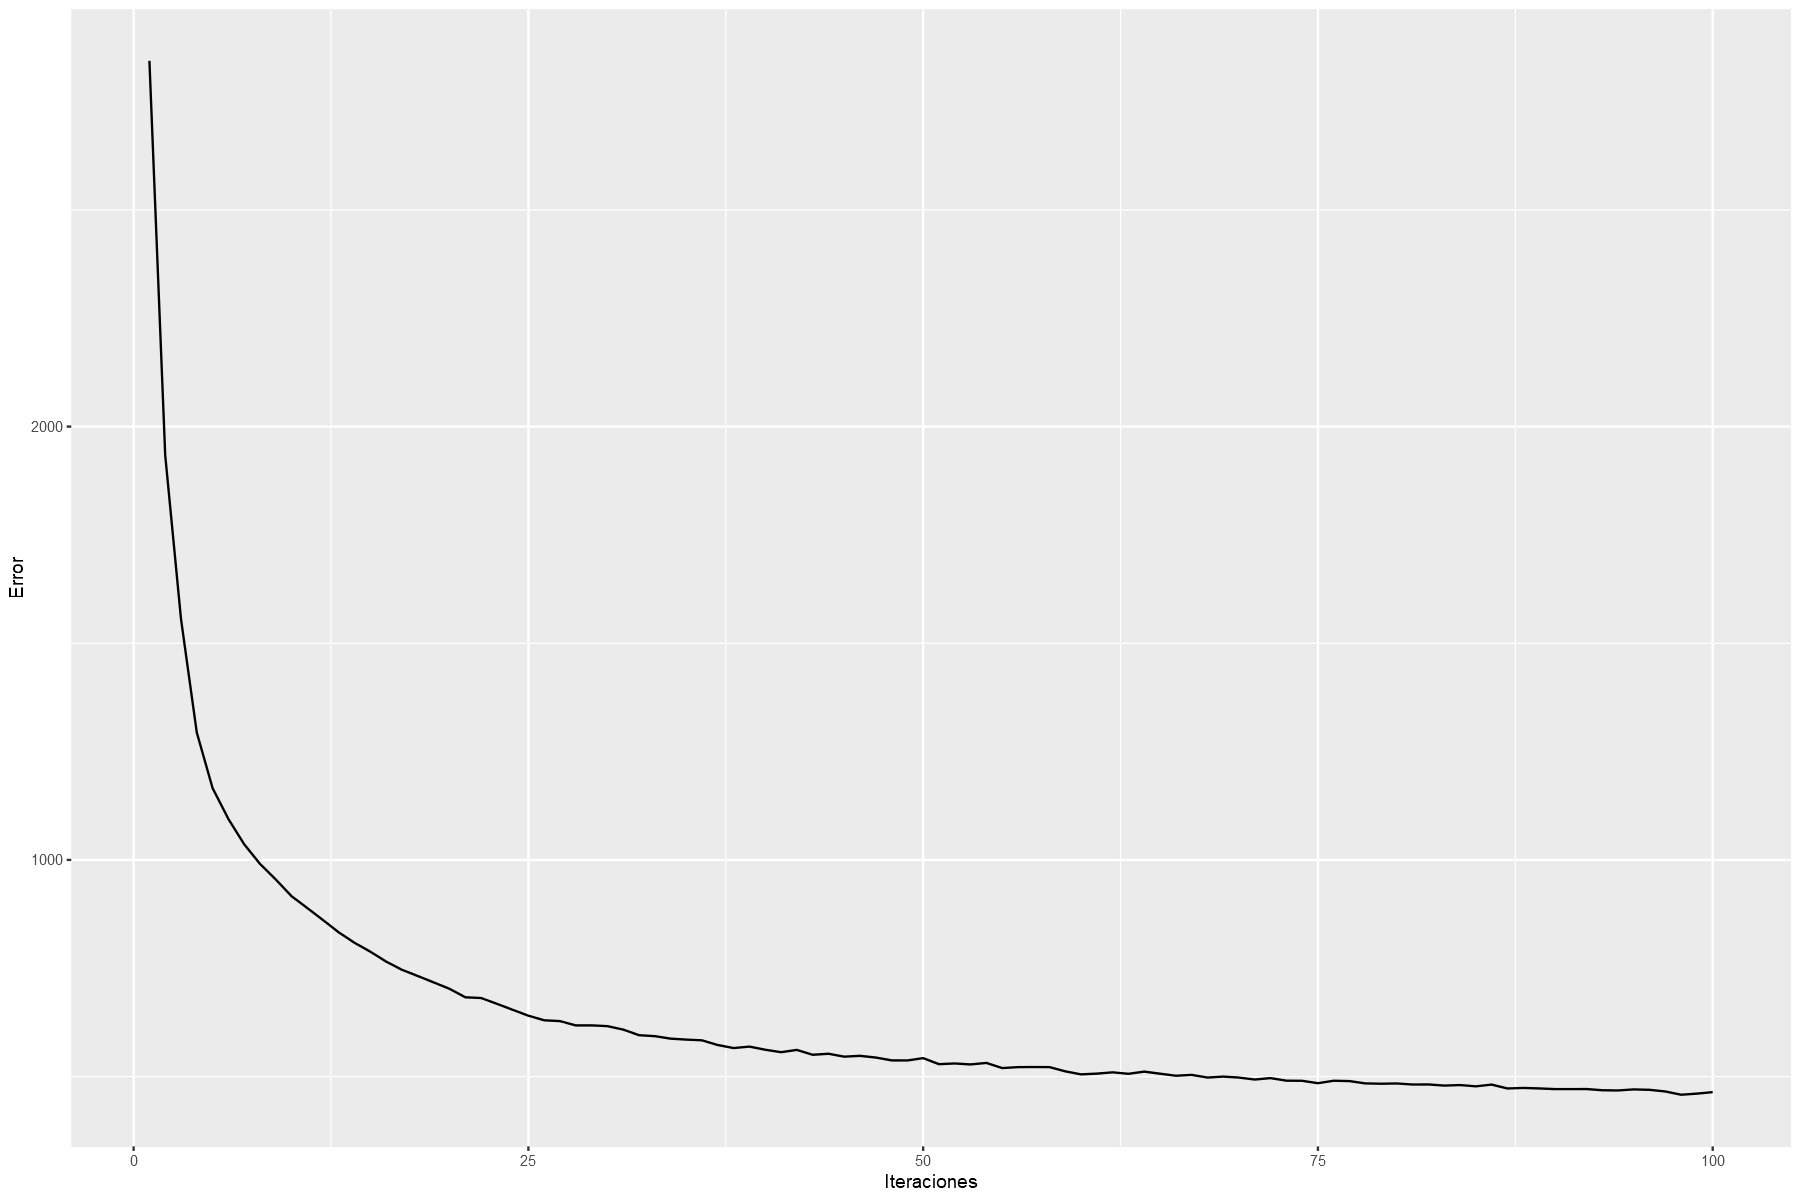

In [29]:
externalValidation(nn1LFit)

# Dibujamos la evolución del error a lo largo de las iteraciones de la red
plotNNErrorEvolution(nn1LFit)

La validación externa nos indica que el entrenamiento es satisfactorio ya que si bien disminuye el valor de kappa, la desmejora es muy reducida.

Como vemos, la curva de entrenamiento es más o menos aceptable ya que no encontramos grandes picos en el error. Sin embargo si observamos que en la iteración número 100 que es donde detenemos nuestro entrenamiento el error aún es descendente. Esto significa que probablemente si continuamos entrenando durante más de 100 iteraciones consigamos unos resultados de desempeño de la red mayores.

In [30]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit2_maxit300 <- train(
    class ~ .,
    data = training,
    method = "mlp",
    trControl = crossValidation,
    metric = "Kappa",
    preProcess=c("center","scale"),
    tuneGrid = data.frame(size=seq(9,30,3)),
    maxit=300
)

In [31]:
# Resultados validación interna
internalValidation(nn1LFit2_maxit300)

Multi-Layer Perceptron 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

Pre-processing: centered (12), scaled (12) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  size  Accuracy   Kappa    
   9    0.9260179  0.9006645
  12    0.9320137  0.9087648
  15    0.9426446  0.9231113
  18    0.9512579  0.9346417
  21    0.9483912  0.9308993
  24    0.9598839  0.9462273
  27    0.9561337  0.9412305
  30    0.9571336  0.9425649

Kappa was used to select the optimal model using the largest value.
The final value used for the model was size = 24.
  size  Accuracy     Kappa  AccuracySD
6   24 0.9598839 0.9462273 0.008284833


Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         606           1        0          0       0
  sittingdown       1         134        0          6       2
  standing          0           3      549          9      15
  standingup        2           6        4        127       6
  walking           0           5       30          5     487

Overall Statistics
                                          
               Accuracy : 0.9525          
                 95% CI : (0.9422, 0.9614)
    No Information Rate : 0.3048          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9362          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9951            0.89933          0.9417


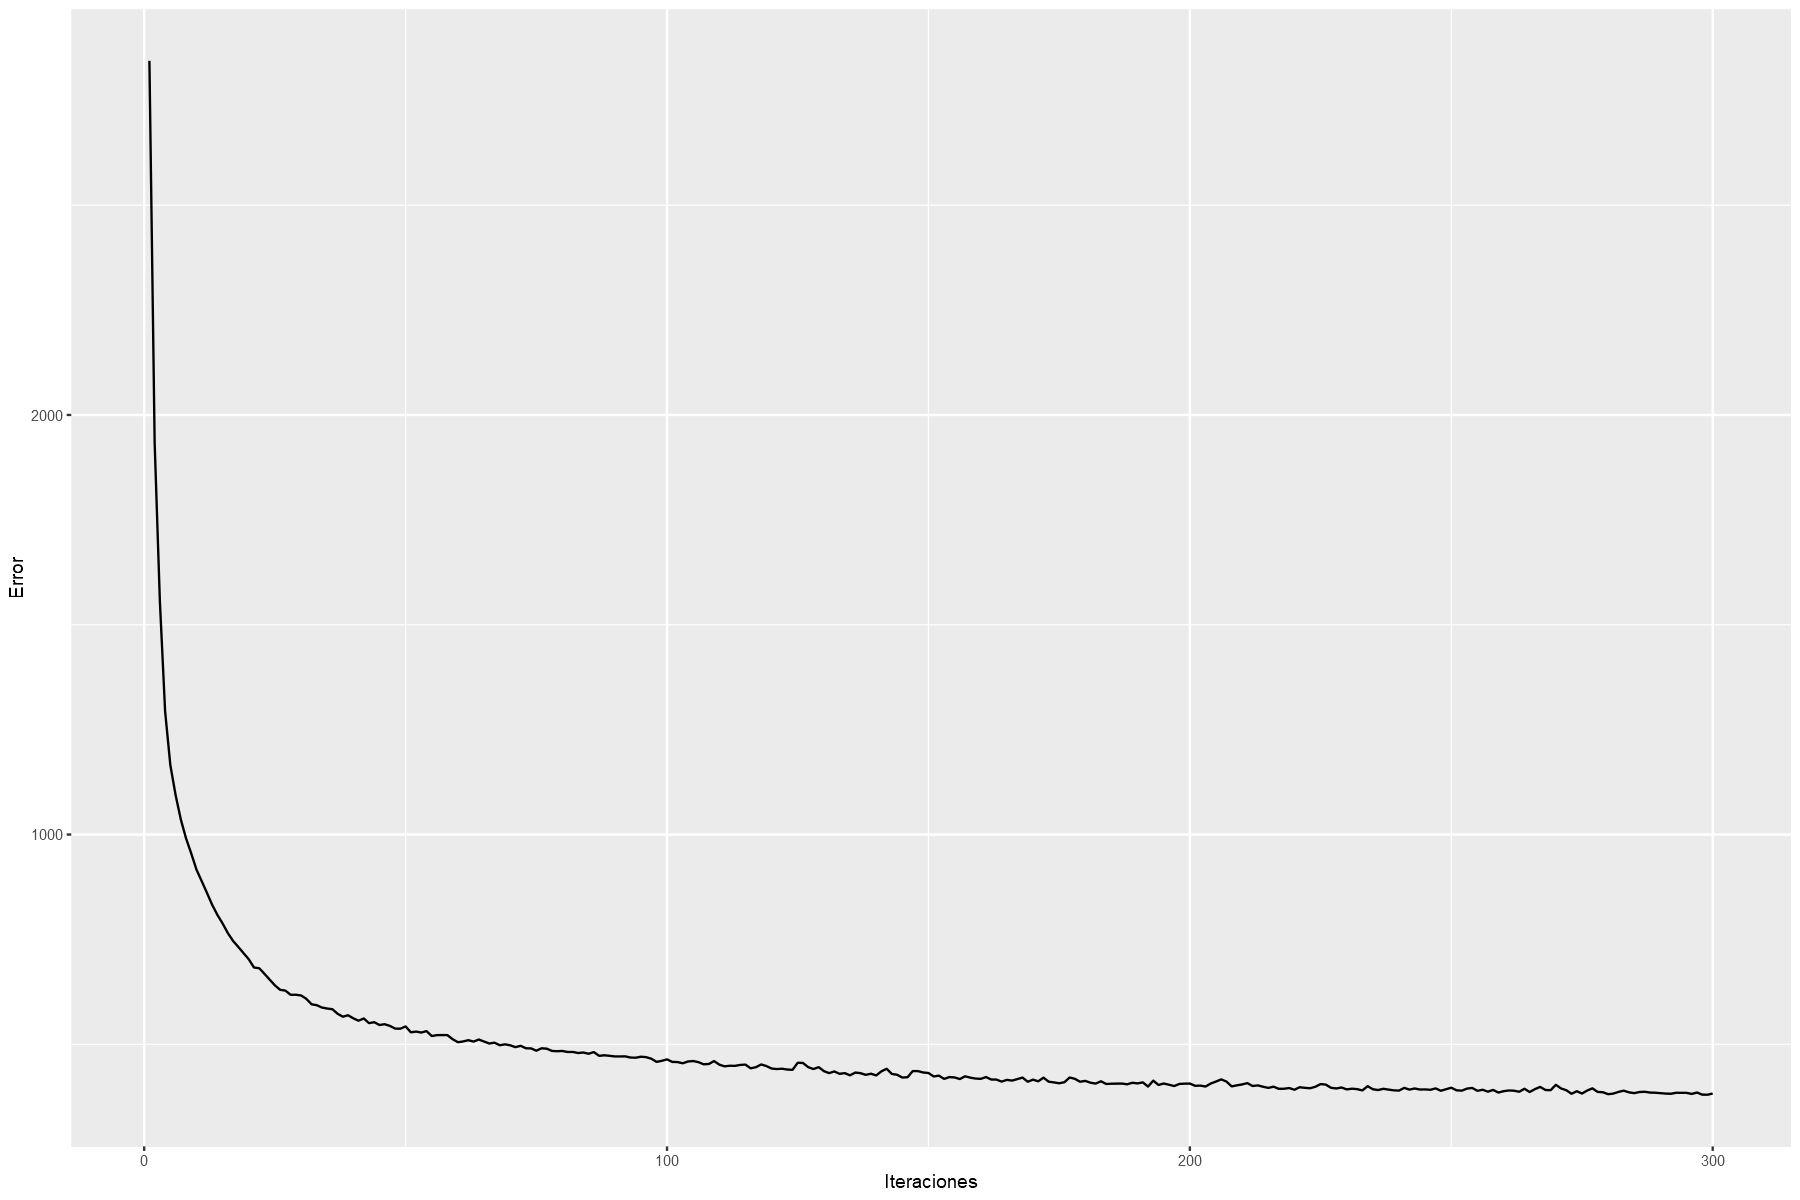

In [32]:
externalValidation(nn1LFit2_maxit300)

# Dibujamos la evolución del error a lo largo de las iteraciones de la red
plotNNErrorEvolution(nn1LFit2_maxit300)

Tanto en la validación interna como externa obtenemos peores resultados, a demás vemos como cuando incrementamos el número de iteraciones nuestra gráfica empieza a mostrar más fluctuaciones en el error. Vamos a intentar a reducir la tasa de aprendizaje para ver que efectos tiene en nuestro modelo.

In [33]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit2_maxit300_lr02 <- train(
    class ~ .,
    data = training,
    method = "mlp",
    trControl = crossValidation,
    metric = "Kappa",
    preProcess=c("center","scale"),
    tuneGrid = data.frame(size=seq(9,30,3)),
    maxit=300,
    leanFuncParam = c(0.01,0)
)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         606           1        0          0       0
  sittingdown       1         134        0          6       2
  standing          0           3      549          9      15
  standingup        2           6        4        127       6
  walking           0           5       30          5     487

Overall Statistics
                                          
               Accuracy : 0.9525          
                 95% CI : (0.9422, 0.9614)
    No Information Rate : 0.3048          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9362          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9951            0.89933          0.9417


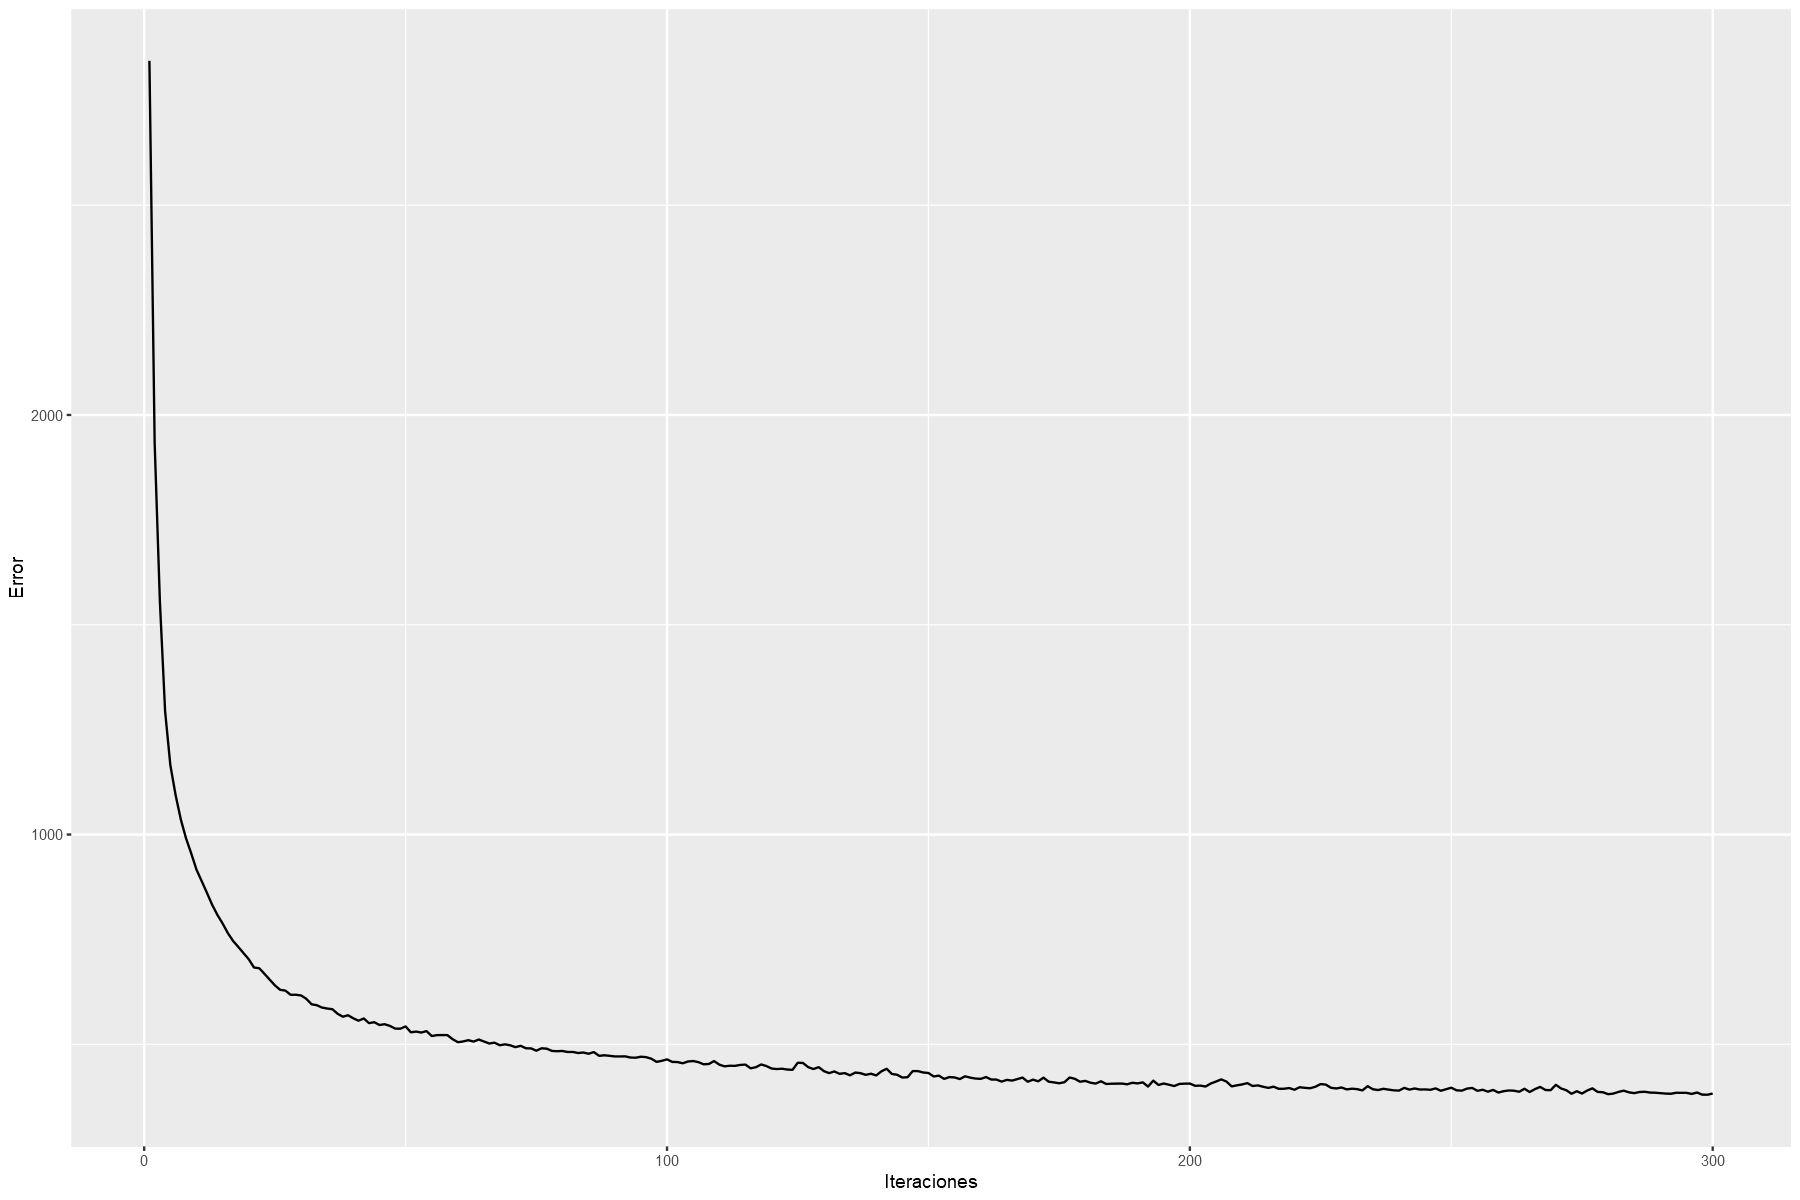

In [34]:
externalValidation(nn1LFit2_maxit300_lr02)

# Dibujamos la evolución del error a lo largo de las iteraciones de la red
plotNNErrorEvolution(nn1LFit2_maxit300_lr02)

Empleando kappa como la métrica de selección de modelo, el último, con 300 iteraciones y el ratio de aprendizaje en 0.01 es el que tiene un valor más alto, sin embargo la diferencia entre el primero modelo con 100 y iteraciones y este es tan insignificativa que no justifica la complejidad añadida, es por esto que en este caso el primer modelo será el seleccionado, 24 neuronas y 100 iteraciones.

A demás como kappa está en torno al 93% probaremos con redes más profundas pero limitando la complejidad de las capas, ya que aún existe margen de mejora.

### 2 capas ocultas

In [35]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn2LFit <- train(
    class ~ .,
    data = training,
    method = "mlpML",
    trControl = crossValidation,
    tuneGrid = expand.grid(layer1=seq(10,14,2),
                           layer2=seq(10,14,2),
                           layer3=0)
)

internalValidation(nn2LFit)

Multi-Layer Perceptron, with multiple layers 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  layer1  layer2  Accuracy   Kappa      
  10      10      0.2983017  0.002995003
  10      12      0.3144162  0.032065073
  10      14      0.3451275  0.073981557
  12      10      0.3145436  0.029232232
  12      12      0.2959229  0.016656857
  12      14      0.2980525  0.006675638
  14      10      0.3255299  0.048481593
  14      12      0.3076842  0.023103335
  14      14      0.3241425  0.047911891

Tuning parameter 'layer3' was held constant at a value of 0
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were layer1 = 10, layer2 = 14 and layer3
 = 0.
  layer1 layer2 layer3  Accuracy
3     10     14     

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         608         148      583        139     510
  sittingdown       0           0        0          0       0
  standing          0           0        0          0       0
  standingup        1           1        0          8       0
  walking           0           0        0          0       0

Overall Statistics
                                          
               Accuracy : 0.3083          
                 95% CI : (0.2881, 0.3291)
    No Information Rate : 0.3048          
    P-Value [Acc > NIR] : 0.375           
                                          
                  Kappa : 0.0067          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                0.998358            0.00000          0.0000


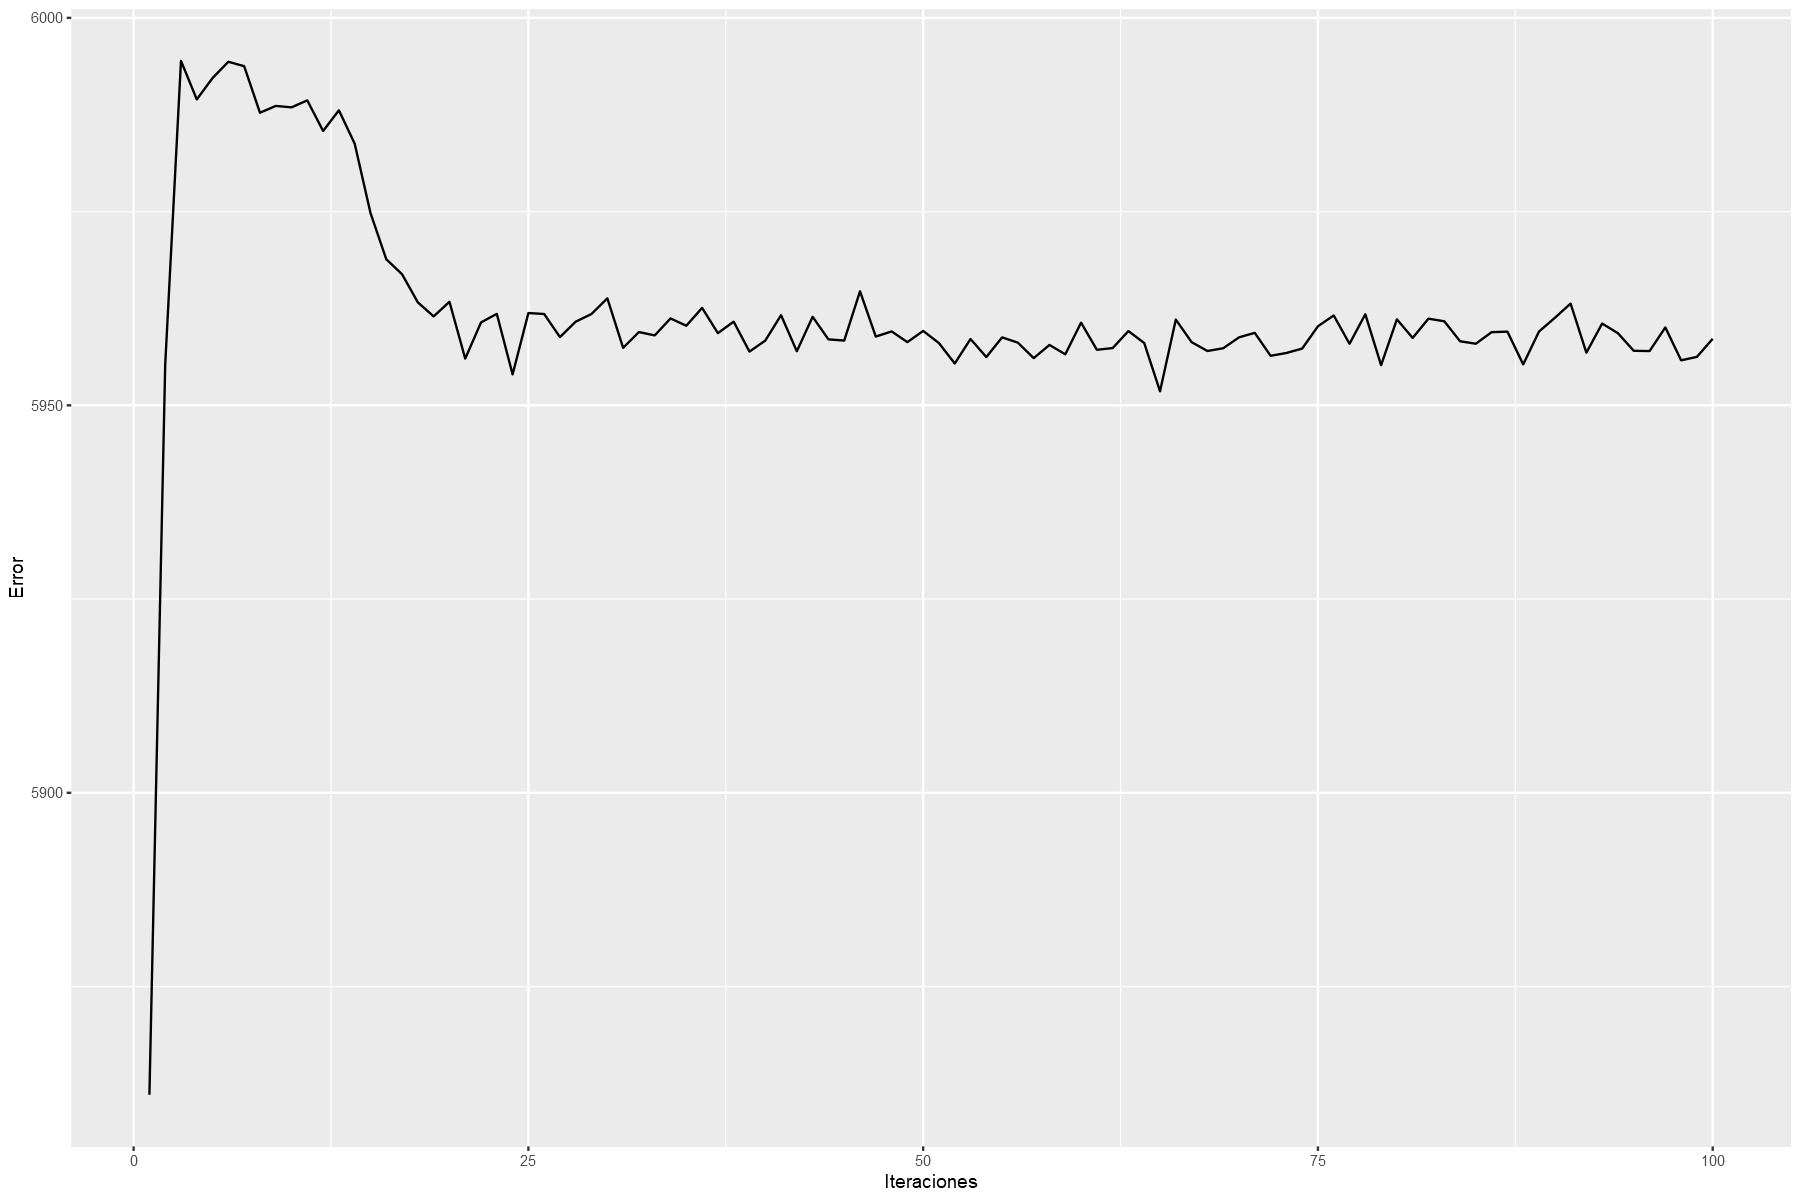

In [36]:
externalValidation(nn2LFit)

# Dibujamos la evolución del error a lo largo de las iteraciones de la red
plotNNErrorEvolution(nn2LFit)

Los resultados con dos capas de primeras son desastrosos, vamos a intentar mejorarlos sólo por ver hasta donde puede ajustar el modelo.

In [37]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn2LFit_500 <- train(
    class ~ .,
    data = training,
    method = "mlpML",
    trControl = crossValidation,
    learnFuncParams = c(0.02,0),
    maxit = 500,
    metric = "Kappa",
    tuneGrid = expand.grid(layer1=seq(10,14,2),
                           layer2=seq(10,14,2),
                           layer3=0)
)

internalValidation(nn2LFit)

Multi-Layer Perceptron, with multiple layers 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  layer1  layer2  Accuracy   Kappa      
  10      10      0.2983017  0.002995003
  10      12      0.3144162  0.032065073
  10      14      0.3451275  0.073981557
  12      10      0.3145436  0.029232232
  12      12      0.2959229  0.016656857
  12      14      0.2980525  0.006675638
  14      10      0.3255299  0.048481593
  14      12      0.3076842  0.023103335
  14      14      0.3241425  0.047911891

Tuning parameter 'layer3' was held constant at a value of 0
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were layer1 = 10, layer2 = 14 and layer3
 = 0.
  layer1 layer2 layer3  Accuracy
3     10     14     

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         476           7        0          0       0
  sittingdown       0           0        0          0       0
  standing          3         100      555        100     286
  standingup        1           1        0          8       0
  walking         129          41       28         39     224

Overall Statistics
                                          
               Accuracy : 0.6321          
                 95% CI : (0.6106, 0.6533)
    No Information Rate : 0.3048          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4852          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.7816            0.00000          0.9520


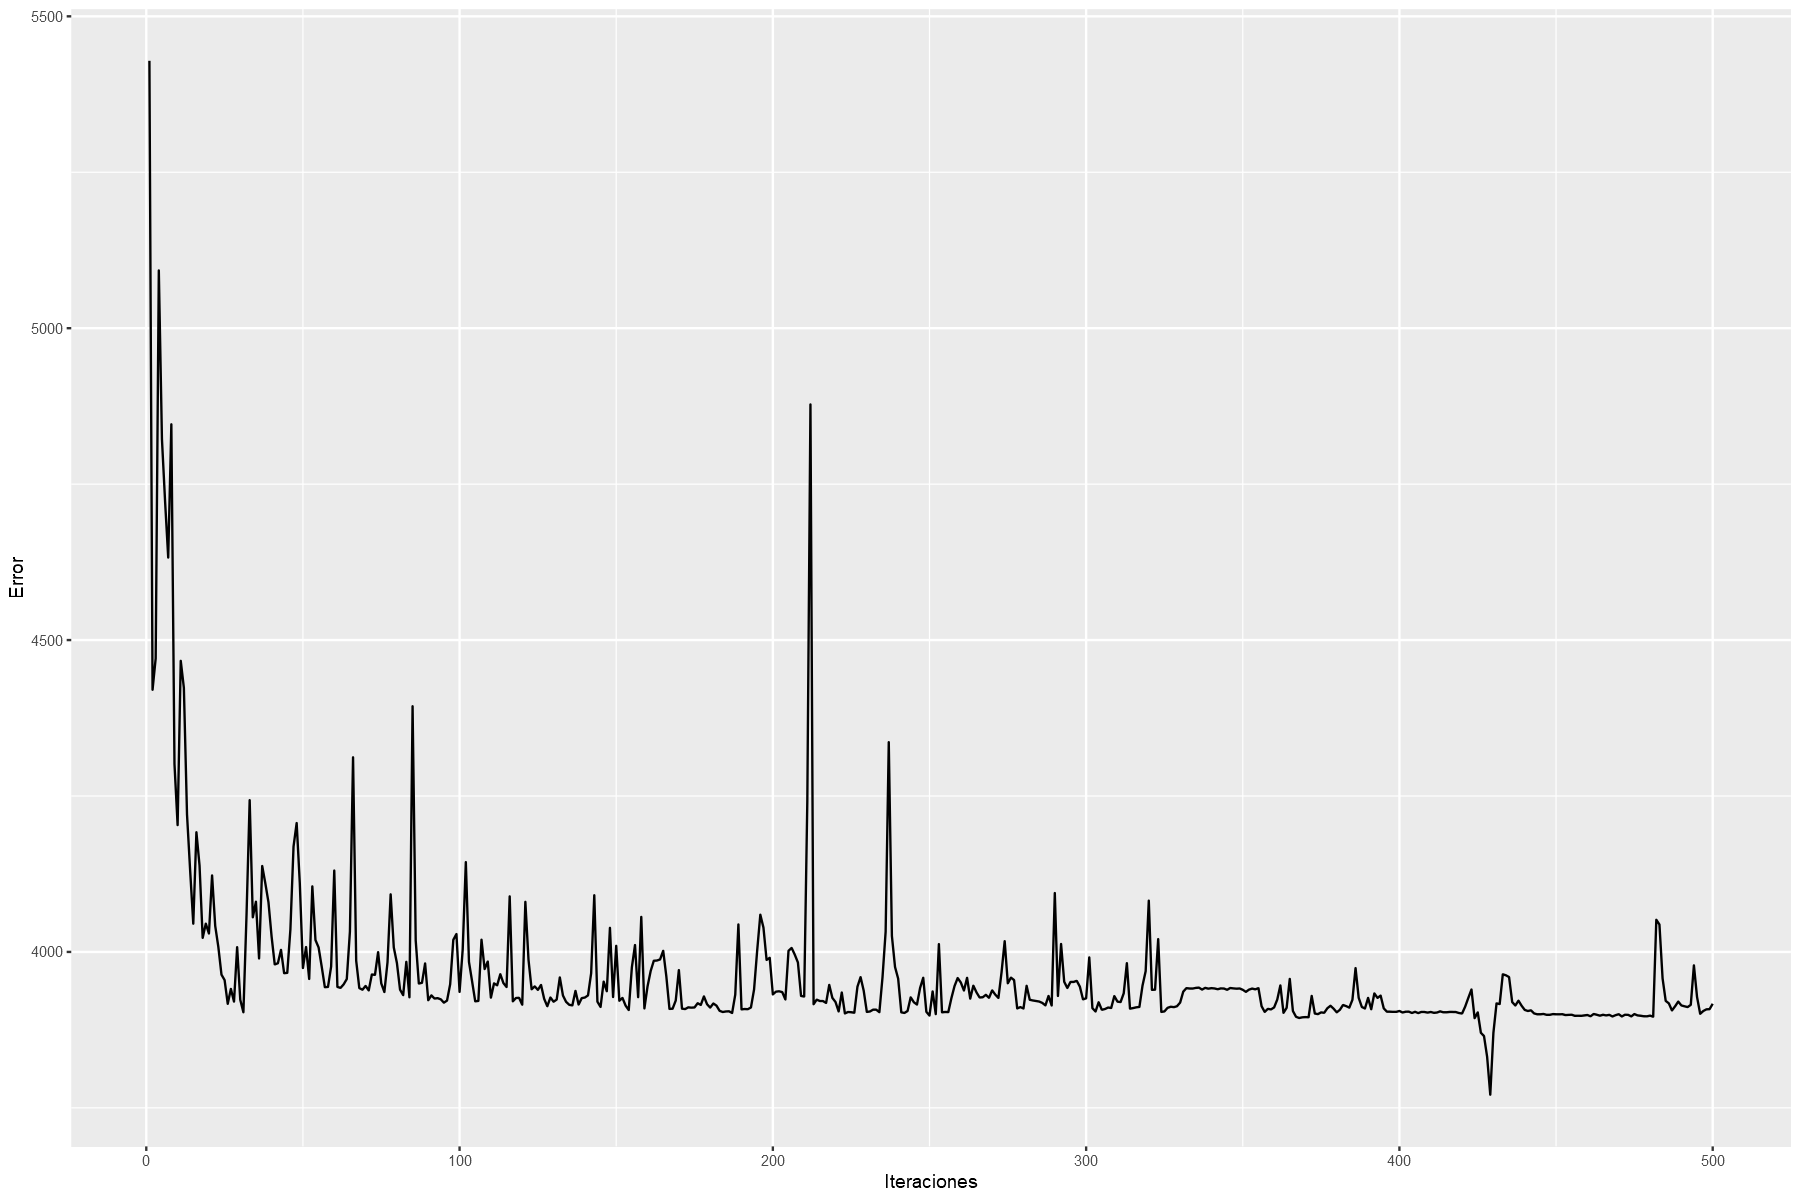

In [38]:
externalValidation(nn2LFit_500)

# Dibujamos la evolución del error a lo largo de las iteraciones de la red
plotNNErrorEvolution(nn2LFit_500)

Vemos que ajustando la tasa de aprendizaje en el modelo de dos capas el error tiende a estabilizarse en torno a 4.000 según la gráfica, por lo que no vamos a seguir intentando reducirlo ni optar a una red de más capas ya que posiblemente el resultado sería peor o la mejoría implicaria el uso de muchos recursos computacionales.

## Máquinas vector soporte

Estos métodos están propiamente relacionados con problemas de clasificación y regresión. Dado un conjunto de ejemplos de entrenamiento (de muestras) podemos etiquetar las clases y entrenar una SVM para construir un modelo que prediga la clase de una nueva muestra. Intuitivamente, una SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo más amplios posibles mediante un hiperplano de separación definido como el vector entre los 2 puntos, de las 2 clases, más cercanos al que se llama vector soporte. Cuando las nuevas muestras se ponen en correspondencia con dicho modelo, en función de los espacios a los que pertenezcan, pueden ser clasificadas a una o la otra clase.

De la misma forma que con los árboles de decisión para las máquinas de vector soporte encontramos diferentes tipos, Lineares, Polinomial y Radial

In [39]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

svmLinealFit <- train(
    class ~ .,
    data = training,
    method = "svmLinear",
    trControl = crossValidation,
    tuneGrid = data.frame(C=c(0.5, 1, 5, 10, 20, 40, 80)),
    metric = "kappa"
)

In [40]:
# Resultados validación interna
internalValidation(svmLinealFit)

Support Vector Machines with Linear Kernel 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
   0.5  0.8247920  0.7633576
   1.0  0.8247939  0.7633728
   5.0  0.8257933  0.7647707
  10.0  0.8266681  0.7659365
  20.0  0.8266680  0.7659098
  40.0  0.8274177  0.7669389
  80.0  0.8276675  0.7672698

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 80.
   C  Accuracy     Kappa AccuracySD
7 80 0.8276675 0.7672698 0.01042368


In [41]:
# Resultados validación externa
externalValidation(svmLinealFit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         609           4        0          1       0
  sittingdown       0         101        3         17      30
  standing          0          24      539         30     138
  standingup        0          17        1         91      10
  walking           0           3       40          8     332

Overall Statistics
                                          
               Accuracy : 0.8368          
                 95% CI : (0.8199, 0.8528)
    No Information Rate : 0.3048          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7797          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  1.0000            0.67785          0.9245


De los resultados anteriores podemos observar que podemos ver que se selecciona el modelo con c = 80 como el que mejor resultado obtiene, sin embargo esta decisión está únicamente basada en kappa. Si tuviésemos en cuenta la mejora obtenida a partir del modelo con C = 10 posiblemente escogeríamos este como es más adecuado, ya que de C = 10 a c = 80 no existe apenas mejora mientras que la complejidad del modelo si que aumenta significativamente.

In [42]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

svmPolyFit <- train(
    class ~ .,
    data = training,
    method = "svmPoly",
    trControl = crossValidation,
    tuneGrid = expand.grid(degree=c(1,3,5,10),C=c(1,3,5),scale = c(0.1, 0.5, 1)),
    metric = "kappa"
)

In [43]:
# Resultados validación interna
internalValidation(svmPolyFit)
externalValidation(svmPolyFit)

Support Vector Machines with Polynomial Kernel 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  degree  C  scale  Accuracy   Kappa    
   1      1  0.1    0.8199177  0.7564644
   1      1  0.5    0.8247920  0.7633576
   1      1  1.0    0.8247939  0.7633728
   1      3  0.1    0.8221692  0.7596500
   1      3  0.5    0.8256681  0.7646264
   1      3  1.0    0.8257933  0.7647277
   1      5  0.1    0.8247920  0.7633576
   1      5  0.5    0.8255436  0.7644141
   1      5  1.0    0.8257933  0.7647707
   3      1  0.1    0.9498840  0.9326394
   3      1  0.5    0.9633847  0.9508791
   3      1  1.0    0.9607609  0.9473990
   3      3  0.1    0.9582584  0.9439497
   3      3  0.5    0.9631340  0.9505681
   3      3  1.0    0.9571357  0.9425583
   3      5  0.1    

Vemos que los polinomios de grado 3 con C 1 y una escala de 0.5 son los que mejor nos sirven para esta tarea de clasificación y a demás con el abanico de datos probados podemos decir que esta conbinación es la mejor ya que cualquier valor que se aleja de esta combinación empeora el resultado obtenido. En este caso se supera a las máquinas vector soporte lineares y por tanto será el modelo escogido para comparar con otros paradigmas.

In [44]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

svmRadialFit <- train(
    class ~ .,
    data = training,
    method = "svmRadial",
    trControl = crossValidation, 
    tuneGrid = expand.grid(sigma=c(1,3),C=c(1,5,6,7)),
    metric = "kappa"
)

In [45]:
# Resultados validación interna
internalValidation(svmRadialFit)
externalValidation(svmRadialFit)

Support Vector Machines with Radial Basis Function Kernel 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  sigma  C  Accuracy   Kappa    
  1      1  0.9522629  0.9356077
  1      5  0.9575128  0.9427491
  1      6  0.9577625  0.9430844
  1      7  0.9578871  0.9432529
  3      1  0.8955240  0.8573442
  3      5  0.9071491  0.8735477
  3      6  0.9071491  0.8735477
  3      7  0.9071491  0.8735477

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 1 and C = 7.
  sigma C  Accuracy     Kappa
4     1 7 0.9578871 0.9432529
Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         603           0        0          0   

Como vemos, otra vez la combinación que obtiene un valor de kappa más elevado a penas consigue superar a combinaciones más simples, por lo que escogeríamos una combinación que tenga un resultado similar pero que al mismo tiempo sea menos compleja. Esto no afecta al aspecto general de esta práctica ya que en la validación externa obtenemos menos que en el modelo anterior y por tanto es el anterior el que compararemos con los otros paradigmas.

## Random forest

Este paradigma contruye múltiples árboles de decisión y a la hora de realizar la predicción devuelve la clase que es la moda, para problemas de clasificación, o la media, para problemas de regresión.

In [46]:
set.seed(uo)
rfFit <- train(
    class ~ .,
    data = training,
    method = "rf",
    trControl = crossValidation,
    tuneGrid = data.frame(mtry=seq(2,30,4)),
    metric = "Kappa"
)

In [47]:
rfFit$finalModel
# Resultados validación interna
internalValidation(rfFit)
externalValidation(rfFit)


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 1.91%
Confusion matrix:
            sitting sittingdown standing standingup walking class.error
sitting        2430           1        0          8       0 0.003690037
sittingdown       5         562        5         13      15 0.063333333
standing          0           0     2309          2      21 0.009862779
standingup        6          27       13        532      13 0.099830795
walking           0           5       19          0    2016 0.011764706

Random Forest 

8002 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7202, 7201, 7202, 7202, 7202, 7202, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9798815  0.9729956
   6    0.9757570  0.9674653
  10    0.9718806  0.9622794
  14    0.9638818  0.9515343
  18    0.9648818  0.9528886
  22    0.9642572  0.9520452
  26    0.9647581  0.9527163
  30    0.9640081  0.9517063

Kappa was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.
  mtry  Accuracy     Kappa  AccuracySD
1    2 0.9798815 0.9729956 0.004572498
Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         609           0        0          0       0
  sittingdown       0         143        0          1       0
  standing

Como se puede observar los datos obtenidos en este último modelo son buenos tanto en la validación interna como en la externa, obteniendo un valor de kappa de 0.9832.

# Comparación de modelos

Para comparar los modelos emplearemos la métrica kappa obtenida en la validación externa de cada modelo.

In [48]:
kappaRF <- 0.9832
kappaKNN <- 0.9658
kappaSVM <- 0.959
kappaNN <- 0.9362
kappaDT <- 0.924

Los modelos con mayor valor Kappa son RF y KNN. Vamos a realizar un test binomial para ver si hay diferencias significaticas entre ellos.

In [49]:
binomialTest <- function(percentageSuccess1, percentageSuccess2, testingData = testing){
  binom.test(
    round(c(percentageSuccess1, 1-percentageSuccess1)* # porcentaje de acierto y error 
            nrow(testingData)), # multiplicado por el número de instancias
                                # para obtener el número total de aciertos y fallos 
    p = percentageSuccess2 # el porcentaje de acierto del modelo con el que comparar
  ) 
}

In [50]:
binomialTest(kappaRF, kappaKNN) # Comparación NN y SVM


	Exact binomial test

data:  round(c(percentageSuccess1, 1 - percentageSuccess1) * nrow(testingData))
number of successes = 1964, number of trials = 1998, p-value =
4.713e-06
alternative hypothesis: true probability of success is not equal to 0.9658
95 percent confidence interval:
 0.9763010 0.9881872
sample estimates:
probability of success 
              0.982983 


In [51]:
binomialTest(kappaRF, kappaSVM) # Comparación NN y RF


	Exact binomial test

data:  round(c(percentageSuccess1, 1 - percentageSuccess1) * nrow(testingData))
number of successes = 1964, number of trials = 1998, p-value =
1.732e-09
alternative hypothesis: true probability of success is not equal to 0.959
95 percent confidence interval:
 0.9763010 0.9881872
sample estimates:
probability of success 
              0.982983 


In [52]:
binomialTest(kappaRF, kappaNN) # Comparación NN y kNN


	Exact binomial test

data:  round(c(percentageSuccess1, 1 - percentageSuccess1) * nrow(testingData))
number of successes = 1964, number of trials = 1998, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.9362
95 percent confidence interval:
 0.9763010 0.9881872
sample estimates:
probability of success 
              0.982983 


En todos los casos anteriores el p-valor es menor de 0.05, por lo tanto se entiende que existe una diferencia significativa entre RF y el resto de modelos probados.

# Interpretación de la comparación y elección del modelo

Tras comprobar en el apartado anterior que las diferencias obtenidas entre el modelo generado por Random Forest y el resto son significativas se podría concluir que este es el mejor paradigma para el problema dado. A demás, Random Forest es el segundo paradigma que requiere menos tiempo de entrenamiento, siendo el primero KNN y el último NN, este último requiere mucho tiempo para el entrenamiento. 

Si nos fijamos si el tipo de paradigma elegido concuerda con el problema dado podemos concluir que también es ideal ya que la totalidad del problema no implica incrementar en gran medida el número de variables.

Por lo tanto, debido a que las diferencias son significativas y que la mejora obtenida justifica el incremento en el tiempo de entrenamiento desde el paradigma inmediatamente "inferior" KNN. Si por ejemplo RF tardase mucho más quizás escogeríamos KNN como el indicado, pero no es el caso.

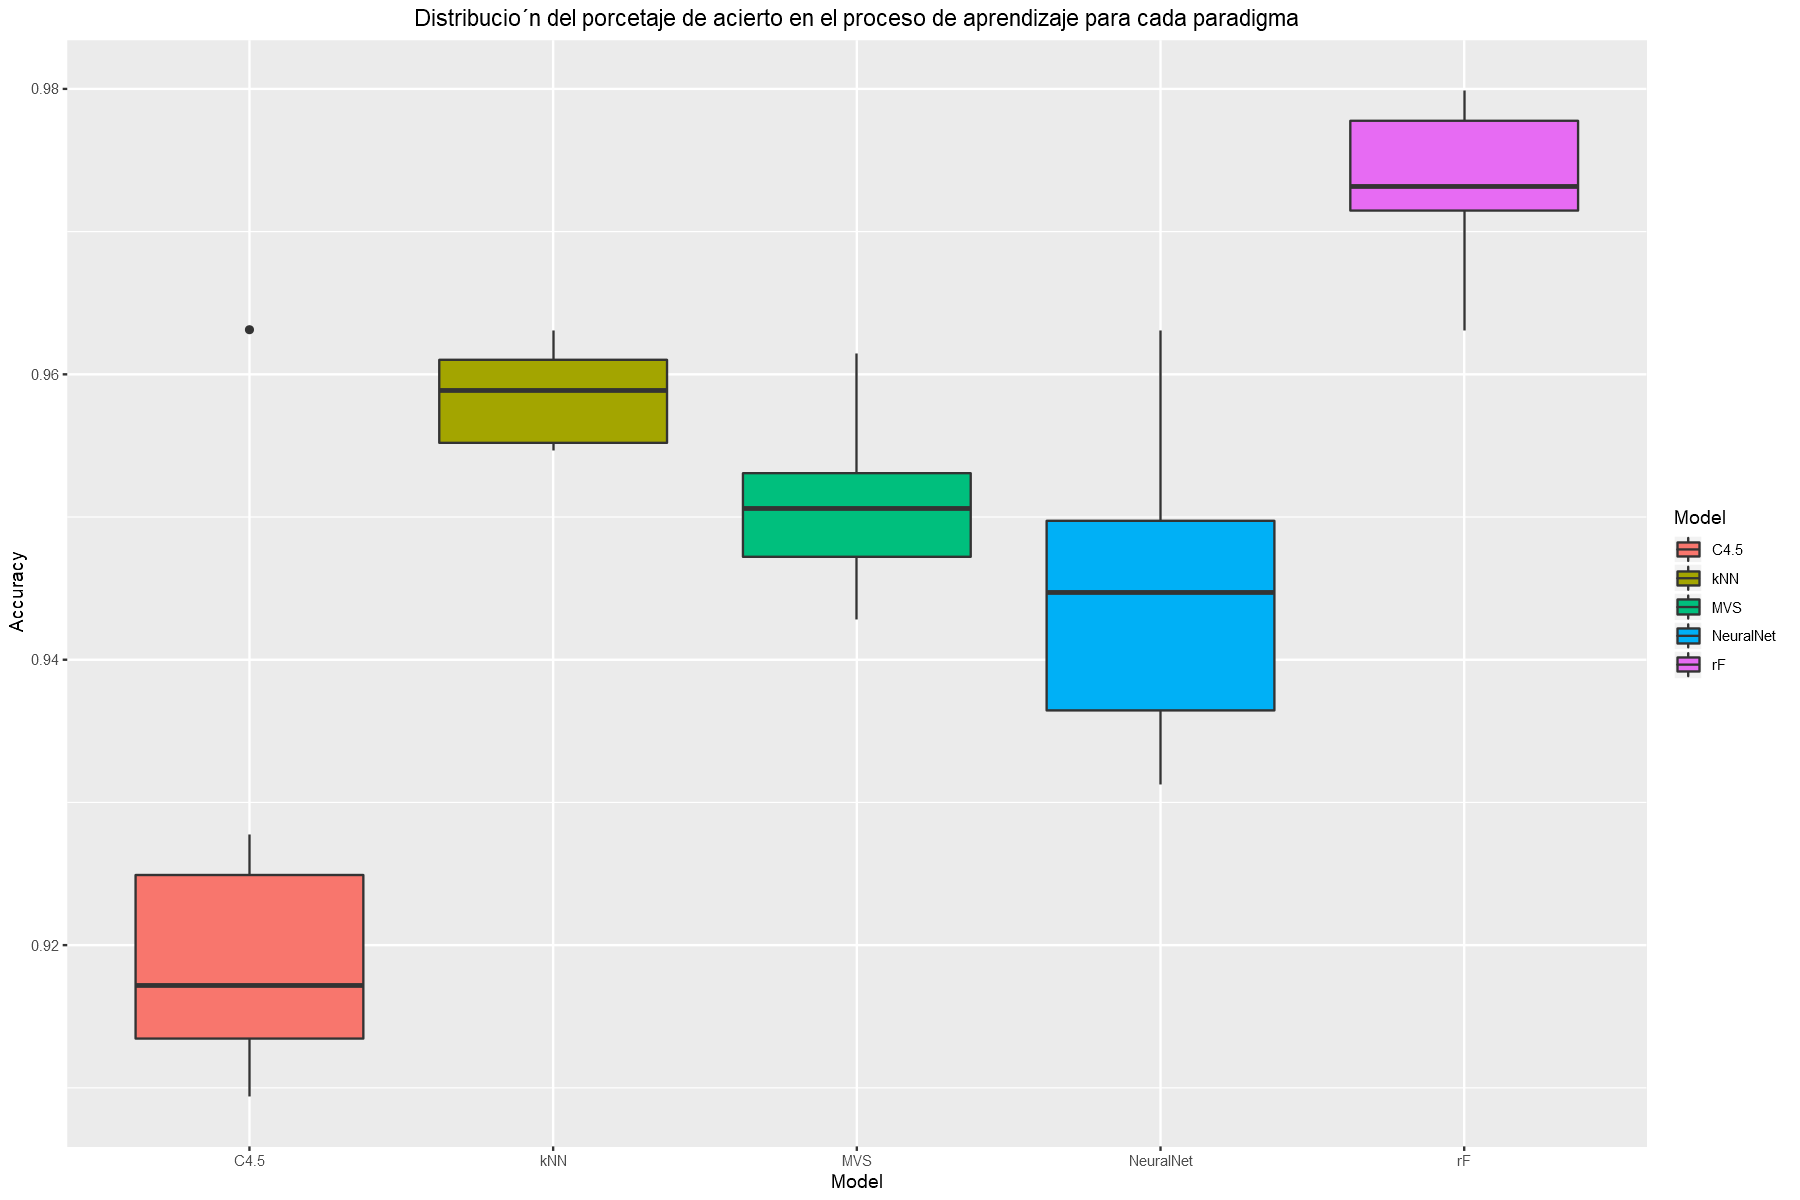

In [53]:
options(repr.plot.width=15, repr.plot.height=10)
dfm.resamp <- data.frame(Accuracy = c(nn1LFit$resample$Kappa,
                                      c4.5Fit$resample$Kappa,
                                      knnFit$resample$Kappa,
                                      svmPolyFit$resample$Kappa,
                                      rfFit$resample$Kappa), 
                        Model = rep(c('NeuralNet','C4.5','kNN', 'MVS', 'rF'), each=10))
ggplot(dfm.resamp,aes(x=Model, y=Accuracy, fill=Model)) + geom_boxplot() +
ggtitle("Distribución del porcetaje de acierto en el proceso de aprendizaje para cada paradigma") +
theme(plot.title = element_text(hjust = 0.5))

En el gráfico anterior podemos ver como se confirma que los modelos construidos sobre obtienen unos valores para kappa significativamente superiores al resto de paradigmas.